## Environment

In [1]:
!cp -R ../input/calibration/calib calib

In [2]:
### Main imports

# !pip install --upgrade "numpy==1.20.2"
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

### Plots

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from cycler import cycler

plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('font', family='serif')
plt.rc('axes', prop_cycle=cycler(color='bmrcgyk'))
plt.rc('image', cmap='gist_rainbow')
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')
# set_matplotlib_formats('png')

### Pandas
pd.set_option("display.max_rows", 100)

### Calibration utils
from calib.eval import *
from calib.calibrators import *
from calib.utils import *

### Measuer
from sklearn.model_selection import train_test_split
from collections import defaultdict
from scipy.special import softmax
from scipy.special import expit as sigmoid

### Also

rs = {'random_state': 0}
rng = np.random.default_rng(seed=0)

## Experimental results

In [3]:
!mkdir tabs

### Load

In [4]:
fpath = '../input/calibration/exp_results'
with open(f'{fpath}/metrics_test.pickle', 'rb') as fin:
    metrics_test = pickle.load(fin)
    
with open(f'{fpath}/metrics_val.pickle', 'rb') as fin:
    metrics_val = pickle.load(fin)

with open(f'{fpath}/rels_test.pickle', 'rb') as fin:
    rels_test = pickle.load(fin)
    
with open(f'{fpath}/rels_val.pickle', 'rb') as fin:
    rels_val = pickle.load(fin)

In [5]:
model_names = [name for dataset, name in rels_test.keys()]

In [6]:
dataset_dict_rename = {
    'cifar10_v1': 'CIFAR-10',
    'cifar100': 'CIFAR-100',
    'imagenet': 'ImageNet',
    'focal_CIFAR10': 'CIFAR-10',
    'focal_CIFAR100': 'CIFAR-100',
    'focal_TinyImageNet': 'TinyImageNet',
}

def rename_dataset(name):
    return dataset_dict_rename[name]

def rename_model(name):
    name = name.replace('tf_', '')
    name = name.capitalize()
    name = name.replace('net_v', 'NetV').replace('netv', 'NetV').replace('net', 'Net')
    name = name.replace('Vgg', 'VGG').replace('vgg', 'VGG')
    name = name.replace('res', 'Res')
    name = name.replace('_cross_entropy_smoothed_smoothing_0.05', ' (LS 0.05)')
    name = name.replace('_cross_entropy', ' (CE)')
    if 'focal' in name:
        name = name.replace('_focal_loss_gamma_', ' (FL ')[:-2] + ')'
    name = name.replace('Wide_ResNet', 'Wide-ResNet-26-10')
    name = name.replace('Inception_v3', 'InceptionV3')
    return name

In [7]:
group_1 = ['cifar10_v1', 'cifar100', 'imagenet']
# group_2 = ['focal_CIFAR10', 'focal_CIFAR100', 'focal_TinyImageNet']

def get_frames(dict_):
    df = pd.DataFrame(dict_).reset_index()
    df = df.rename({'level_0': 'Датасет', 'level_1': 'Модель'}, axis=1)
    mask = df['Датасет'].isin(group_1)
    df['Датасет'] = df['Датасет'].transform(rename_dataset)
    df['Модель'] = df['Модель'].transform(rename_model)
    df1 = df[mask].sort_values(['Датасет', 'Модель'])
    df2 = df[~mask].sort_values(['Датасет', 'Модель'])
    return df1, df2

In [8]:
def get_loss_frame(dict_, method='До калибровки'):
    _, df = get_frames(dict_)
    data_model_loss = (df['Датасет'] + ' ' + df['Модель']).str.split(' ', 2)
    data_model_loss = data_model_loss.transform(tuple)
    idx = pd.MultiIndex.from_tuples(data_model_loss)
    data = df[method]
    res_df = pd.Series(data.values, index=idx).unstack(level=-1)
    res_df.columns = [col[1:-1] for col in res_df.columns]
    res_df = res_df.reset_index()
    res_df = res_df.rename({'level_0': 'Датасет', 'level_1': 'Модель'}, axis=1)
    return res_df

In [9]:
format_kwargs = {
    'ACC': {'mode': 'max', 'format_string': '%.2f'},
    'ECE': {'mode': 'min', 'format_string': '%.2f'},
    'cwECE': {'mode': 'min', 'format_string': '%.3f'},
    'MCE': {'mode': 'min', 'format_string': '%.2f'},
    'BS': {'mode': 'min', 'format_string': '%.3f'},
    'NLL': {'mode': 'min', 'format_string': '%.3f'},
}


def format_tex(data, mode='min', format_string='%.2f'):
    if mode == 'min':
        mask = data != data.min()
    elif mode == 'max':
        mask = data != data.max()
    else:
        mask = np.ones_like(data, dtype=bool)
    bolded = data.apply(lambda x : 'BOLDLEFT%sBOLDRIGHT' % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(mask, bolded)

In [10]:
captions = {
    'ACC': r'Accuracy, \% (больше -- лучше) -- доля правильных ответов',
    'ECE': r'ECE, \% -- Expected Calibration Error, (меньше -- лучше), 15 бинов',
    'cwECE': r'cwECE, \% -- Classwise Expected Calibration Error (меньше -- лучше), 15 бинов',
    'MCE': r'MCE, \% -- Maximum Calibration Error, (меньше -- лучше), 15 бинов',
    'BS': r'Brier Score (меньше -- лучше)',
    'NLL': r'Negative Log-Likelihood (меньше -- лучше)',
}

def get_label(metric_name, group):
    label = f'tab:metrics:{metric_name}_{group}'
    return f'\label{{{label}}}'

def get_caption(metric_name, group):
    caption = f'{captions[metric_name]}, группа {group}'
    return f'\caption{{{caption}}}'

In [11]:
def df_to_tex(df, label, caption):
    df_tex = df.to_latex(index=False, position='h!')
    df_tex = df_tex.replace('BOLDLEFT', r'\textbf{').replace('BOLDRIGHT', r'}')
    df_tex = df_tex.replace(r'\begin{tabular}', r'\resizebox{\textwidth}{!}{\begin{tabular}')
    df_tex = df_tex.replace(r'\end{tabular}', r'\end{tabular}%' + '\n}')
    df_tex = df_tex.replace(r'{lllllllll}', r'{llccccccc}')
    df_tex = df_tex.replace(r'\end{table}', caption + '\n' + r'\end{table}')
    df_tex = df_tex.replace(r'\end{table}', label + '\n' + r'\end{table}')
    return df_tex

In [12]:
def save_metric_table(df, metric_name, group):
    label = get_label(metric_name, group)
    caption = get_caption(metric_name, group)
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(format_tex, **format_kwargs[metric_name], axis=1)
    df_tex = df_to_tex(df, label, caption)
    with open(f'tabs/metrics_{metric_name}_{group}.tex', 'w') as fout:
        fout.write(df_tex)

In [13]:
# MAIN TABLES
for metric_name, dict_ in metrics_test.items():
    df1, df2 = get_frames(dict_)
    save_metric_table(df1, metric_name, 1)
    save_metric_table(df2, metric_name, 2)

In [14]:
# LOSS TABLES
for metric_name, dict_ in metrics_test.items():
    df = get_loss_frame(dict_, method='До калибровки')
    df.iloc[:, 2:] = df.iloc[:, 2:].apply(format_tex, **format_kwargs[metric_name], axis=1)
    label = f'tab:fl:{metric_name}'
    label = f'\label{{{label}}}'
    caption = f'{captions[metric_name]} без постобработки, столбцы соответствуют разным функциям потерь'
    caption = f'\caption{{{caption}}}'
    df_tex = df_to_tex(df, label, caption)
    df_tex = df_tex.replace(r'\begin{table}', r'% \begin{table}').replace(r'\end{table}', r'% \end{table}')
    with open(f'tabs/fl_{metric_name}.tex', 'w') as fout:
        fout.write(df_tex)

In [15]:
!zip -r tabs.zip tabs

  adding: tabs/ (stored 0%)
  adding: tabs/metrics_BS_1.tex (deflated 79%)
  adding: tabs/fl_ACC.tex (deflated 68%)
  adding: tabs/fl_cwECE.tex (deflated 57%)
  adding: tabs/fl_MCE.tex (deflated 59%)
  adding: tabs/metrics_NLL_2.tex (deflated 80%)
  adding: tabs/metrics_NLL_1.tex (deflated 77%)
  adding: tabs/fl_ECE.tex (deflated 59%)
  adding: tabs/metrics_ACC_1.tex (deflated 80%)
  adding: tabs/fl_NLL.tex (deflated 57%)
  adding: tabs/metrics_MCE_1.tex (deflated 74%)
  adding: tabs/metrics_MCE_2.tex (deflated 80%)
  adding: tabs/metrics_BS_2.tex (deflated 85%)
  adding: tabs/metrics_ECE_1.tex (deflated 79%)
  adding: tabs/metrics_ACC_2.tex (deflated 84%)
  adding: tabs/metrics_cwECE_1.tex (deflated 82%)
  adding: tabs/metrics_ECE_2.tex (deflated 83%)
  adding: tabs/metrics_cwECE_2.tex (deflated 85%)
  adding: tabs/fl_BS.tex (deflated 60%)


# Plots

## All reliability diagrams

In [16]:
!mkdir vis

In [17]:
!mkdir all_rels_1 all_rels_2

In [18]:
from tqdm.auto import tqdm

for data_model in tqdm(rels_test):
    plt.figure(figsize=(11, 8))
    for i, (name, rel) in enumerate(rels_test[data_model].items(), 1):
        plt.subplot(2, 3, i)
        reliability_plot(*rel)
        plt.title(name)
        if i == 6:
            break
    data = rename_dataset(data_model[0])
    model = rename_model(data_model[1])
    plt.suptitle(f'Датасет: {data},  модель: {model}')
    plt.tight_layout()
    group = 1 if data_model[0] in group_1 else 2
    savepath = f'all_rels_{group}/{data} {model}.pdf'
    plt.savefig(savepath)
    plt.close()

  0%|          | 0/77 [00:00<?, ?it/s]

In [19]:
!pip install PyPDF2

     |████████████████████████████████| 77 kB 349 kB/s eta 0:00:01
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61085 sha256=7d9937e990685149c9f3067c0c0b416990f5279cfebba8bd3bba04455bc8bdd3
  Stored in directory: /root/.cache/pip/wheels/80/1a/24/648467ade3a77ed20f35cfd2badd32134e96dd25ca811e64b3
Successfully built PyPDF2


In [20]:
from PyPDF2 import PdfFileMerger

for group in [1, 2]:
    fig_dir = f'all_rels_{group}'
    merger = PdfFileMerger()
    for fname in sorted(os.listdir(fig_dir)):
        merger.append(os.path.join(fig_dir, fname))
    merger.write(f'vis/ReliabilityDiagrams_group_{group}.pdf')       
    merger.close()

In [21]:
!rm -rf all_rels_1 all_rels_2

## Artificial

In [22]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=20000, n_features=19,
                           n_informative=3, n_redundant=10,
                           random_state=0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)
model = LinearSVC(random_state=0, max_iter=10000)
_ = model.fit(X_train, y_train)

y_confs_val = model.decision_function(X_val)
y_min = y_confs_val.min()
y_max = y_confs_val.max()

y_confs_val = (y_confs_val - y_min) / (y_max - y_min)
y_confs_test = model.decision_function(X_test)
y_confs_test = (y_confs_test - y_min) / (y_max - y_min)
y_confs_test = np.clip(y_confs_test, 0, 1)

In [23]:
def binconf2mc(y_confs):
    return np.stack([1 - y_confs, y_confs], axis=1)

bin_confs_val, bin_accs_val, weights_val = bins_reliability_binary(y_val, y_confs_val, n_bins=10)
bin_confs_test, bin_accs_test, weights_test = bins_reliability_binary(y_test, y_confs_test, n_bins=10)

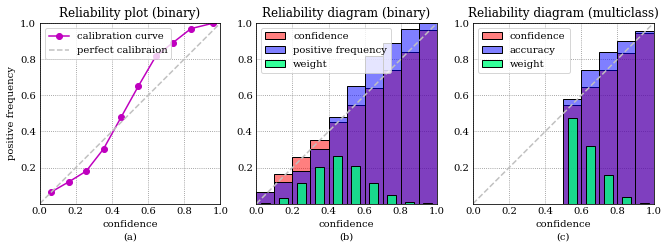

In [24]:
plt.figure(figsize=(11, 5))
plt.subplot(131)
plt.plot(bin_confs_test, bin_accs_test, marker='o', label='calibration curve', color='m')
plt.plot([0, 1], [0, 1], color='silver', linestyle='--', label='perfect calibraion')
hist_plot_adjust(pad=0.0)
plt.xlabel('confidence')
plt.ylabel('positive frequency')
plt.title('Reliability plot (binary)')
plt.legend(loc='upper left')
plt.text(0.5, -0.2, '(a)', ha='center')

plt.subplot(132)
reliability_plot(bin_confs_test, bin_accs_test, weights_test, name='Reliability diagram (binary)', acc_label='positive frequency')
plt.text(0.5, -0.2, '(b)', ha='center')

plt.subplot(133)
ReliabilityPlot(y_test, binconf2mc(y_confs_test), name='Reliability diagram (multiclass)')
plt.text(0.5, -0.2, '(c)', ha='center')

plt.savefig('vis/rel_intro')

In [25]:
def _aux():
    plt.scatter(bin_confs_test, bin_accs_test, marker='o', color='m', label='before calibration')
    plt.plot([0, 1], [0, 1], color='silver', linestyle='--', label='perfect calibraion', zorder=-2)
    plt.xlabel('confidence')
#     plt.title('Reliability plot (binary)')
    hist_plot_adjust(pad=0.0)
    plt.legend(loc='upper left')

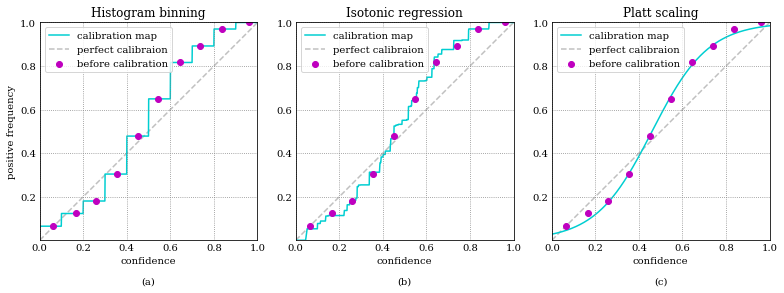

In [26]:
plt.figure(figsize=(11, 5))

color = 'darkturquoise'
xs = np.linspace(0, 1, 1000)

plt.subplot(131)
plt.title('Histogram binning')
plt.text(0.5, -0.2, '(a)', ha='center')
plt.ylabel('positive frequency')
calibrator = HistogramBinningBinary(n_bins=10).fit(y_confs_test, y_test)
y_confs_test_calib = calibrator.transform(y_confs_test)
bin_confs_test_calib, bin_accs_test_calib, _ = bins_reliability_binary(y_test, y_confs_test_calib, n_bins=10)
# plt.scatter(bin_confs_test_calib, bin_accs_test_calib, marker='o', color='b', label='after')
ys = calibrator.transform(xs)
plt.plot(xs, ys, c=color, label='calibration map', zorder=-1)
_aux()

plt.subplot(132)
plt.title('Isotonic regression')
plt.text(0.5, -0.2, '(b)', ha='center')
calibrator = IsotonicRegressionBinary().fit(y_confs_test, y_test)
y_confs_test_calib = calibrator.transform(y_confs_test)
bin_confs_test_calib, bin_accs_test_calib, _ = bins_reliability_binary(y_test, y_confs_test_calib, n_bins=10)
# plt.scatter(bin_confs_test_calib, bin_accs_test_calib, marker='o', color='b', label='after')
ys = calibrator.transform(xs)
plt.plot(xs, ys, c=color, label='calibration map', zorder=-1)
_aux()

plt.subplot(133)
plt.title('Platt scaling')
plt.text(0.5, -0.2, '(c)', ha='center')
calibrator = LogitScaling(scale_type='platt').fit(y_confs_test, y_test)
y_confs_test_calib = calibrator.transform(y_confs_test)
bin_confs_test_calib, bin_accs_test_calib, _ = bins_reliability_binary(y_test, y_confs_test_calib, n_bins=10)
# plt.scatter(bin_confs_test_calib, bin_accs_test_calib, marker='o', color='b', label='after')
ys = calibrator.transform(xs)
plt.plot(xs, ys, c=color, label='calibration map', zorder=-1)
_aux()

plt.tight_layout()
plt.savefig('vis/calibs_binary')

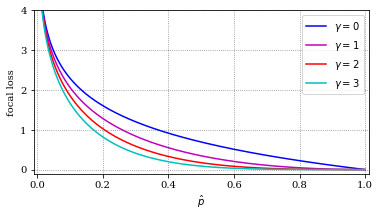

In [27]:
ps = np.linspace(0.001, 1, 1000)
def fl(ps, gamma=1.0):
    return - (1 - ps) ** gamma * np.log(ps)

plt.figure(figsize=(6, 3))
for gamma in np.arange(4):
    plt.plot(ps, fl(ps, gamma=gamma), label=f'$\gamma={gamma}$')
plt.ylim(-0.1, 4)
plt.yticks(np.arange(5))
plt.xlim(-0.01, 1.01)
plt.ylabel('focal loss')
plt.xlabel('$\hat{p}$')
plt.legend()
plt.savefig('vis/focal_loss')

In [28]:
!zip -r vis.zip vis
!rm -rf tabs vis calib

  adding: vis/ (stored 0%)
  adding: vis/ReliabilityDiagrams_group_2.pdf (deflated 70%)
  adding: vis/ReliabilityDiagrams_group_1.pdf (deflated 68%)
  adding: vis/focal_loss.pdf (deflated 38%)
  adding: vis/calibs_binary.pdf (deflated 27%)
  adding: vis/rel_intro.pdf (deflated 25%)
